In [16]:
import numpy as np
from scipy.linalg.interpolative import interp_decomp
import matplotlib.pyplot as plt

In [17]:
# Use scipy's implementation of the interpolative decomposition
# Instead of the matrix cross interpolation M = C @ P^-1 @ R
# it factorizes as M = A @ P with A = M[:, idx]
def interpolative_decomposition(M, eps_or_k=1e-5, k_min=2):
    r = min(M.shape)
    if r <= k_min:
        k = r
        idx, proj = interp_decomp(M, eps_or_k=k) #eps_or_k = precision of decomposition
    elif isinstance(eps_or_k, int): #checks if eps is an integer
        k = min(r, eps_or_k)
        idx, proj = interp_decomp(M, eps_or_k=k)
    else:
        k, idx,  proj = interp_decomp(M, eps_or_k=eps_or_k)
        if k <= k_min:
            k = min(r, k_min) #is it not enough to put k = k_min? 
                              #r>k_min otherwise first condition would have been true
            idx, proj = interp_decomp(M, eps_or_k=k)
    A = M[:, idx[:k]]
    P = np.concatenate([np.eye(k), proj], axis=1)[:, np.argsort(idx)]
    return A, P, k, idx[:k]

# k is the 'compressed' rank = number of pivot columns
# idx is the array with entries the indeces of the pivot columns
# proj = matrix R s.t. M[:,idx[:k]]*R = M[:,idx[k:]] 
# P = matrix s.t.  M[:,idx[:k]]*P = M (approximated)

In [18]:
class function:  # certain function f(x) with x given as binary

    def __init__(self, f):
        self.cache = {}
        self.f = f #store function passed during instantiation


    def __call__(self, *args, **kwds):
        
        if args in self.cache:
            return self.cache[*args]
        else:
            val = self.f(*args)
            self.cache[*args] = val
            return val
    
    def cache_size(self): #size of cache = number of current evaluations
        return len(self.cache) #return the number of entries in the cache
        


### FIRST VERSION

In [12]:
# implement the tensor cross interpolation
"""
def tensor_cross_interpolation(tensor, func_vals, L, d=2, eps_or_chi=1e-6, iters=6):
    # random initial choice for index sets
    idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma
    As = [np.array([[[tensor(*idxs[:j], i, *idxs[j+1:])] for i in range(d)]])
          for j in range(L)]
    As[1:] /= tensor(*idxs)
    #this sort of corresponds to inserting the P^-1 0-dimensional slices
    #i.e. if I don't put this, evaluating F(σ1,...,σL)= As*...*As = F(σ1,..,σL)^L, when it should give just F!
    eval = []
    err_max = []
    err_2 = []
    I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l
    # sweep
    for i in range(iters):
        #print(f'Sweep: {i+1:d}.')
        As, I = left_to_right_sweep(tensor, As, I, J, L, d, eps_or_chi)
        As, J = right_to_left_sweep(tensor, As, I, J, L, d, eps_or_chi)
    return As, J, eval

def left_to_right_sweep(tensor, func_vals, As, I, J, L, d, eps_or_chi, eval):
    # sweep left to right
    for bond in range(L-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape #chil = number of rows in array I_l: number of combinations (σ1,..,σl)
        chir, _ = J[bond+1].shape #which corresponds to number of "points" on which I am evaluating function

        Pi = np.zeros(chil, d, d, chir)
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond][jr,:])
                        Pi[il,s1,s2,jr] = val
        # decompose using interpolative decomposition:
        # Pi = P^T @ A^T, A^T = Pi[idx,:]
        A, P, k, idx = interpolative_decomposition(Pi.T, eps_or_k=eps_or_chi)
        # update indices using idxs c I[bond] x {0, 1, ..., d-1}
        I[bond+1] = np.array([np.append(I[bond][i//d], [i%d]) for i in idx])
        # update tensors
        As[bond] = P.T.reshape(chil, d, k)
        As[bond+1] = A.T.reshape(k, d, chir)
        eval.append(tensor.cache_size())

        if bond==0:
            func_interp = np.squeeze(As[0])
            func_updated = func_interp
            for A in As[1:]:
                func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
                func_interp = func_interp.reshape(-1, A.shape[-1])
        else: #should work just with this because the for cycle goes up to bond=L-2
            func_updated = np.einsum('ia, ajb -> ijb', func_updated, As[bond])
            func_interp = func_updated
            for A in As[(bond+1):]:
                func_interp =  np.einsum('ia, ajb -> ijb', func_interp, A)
                func_interp = func_interp.reshape(-1, A.shape[-1])
        """elif bond == L-1:
            func_updated = np.einsum('ia, ajb -> ijb', func_updated, As[bond])
            func_interp = func_updated
            func_interp = func_interp.reshape(-1, A.shape[-1])"""


        func_interp = np.squeeze(func_interp)

        difference = func_vals-func_interp
        err_max.append(np.max(np.abs(difference)))
        err_2.append(np.linalg.norm(difference)**2)

    return As, I

def right_to_left_sweep(tensor, func_vals, As, I, J, L, d, eps_or_chi):
    # sweep right to left
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = np.zeros(chil, d, d, chir)
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond][jr,:])
                        Pi[il,s1,s2,jr] = val

        # decompose using interpolative decomposition:
        # Pi = A @ P, A = Pi[:,idx]
        A, P, k, idx = interpolative_decomposition(Pi, eps_or_k=eps_or_chi)
        # update indices using idxs c {0, 1, ..., d-1} x J[bond+1]
        J[bond] = np.array([np.append([i//chir], J[bond+1][i%chir]) for i in idx])
        # update tensors
        As[bond] = A.reshape(chil, d, k)
        As[bond+1] = P.reshape(k, d, chir)
        eval.append(tensor.cache_size())

        if bond == L-2:
        As_new = np.einsum('ia, ajb -> ijb', As[] As[bond+1])

        

        difference = func_vals-func_interp
        err_max.append(np.max(np.abs(difference)))
        err_2.append(np.linalg.norm(difference)**2)

    return As, J
    """

SyntaxError: invalid syntax (1766297997.py, line 59)

### SECOND VERSION

In [79]:
# implement the tensor cross interpolation
def tensor_cross_interpolation(tensor, func_vals, L, d=2, eps_or_chi=1e-6, iters=6):
    # random initial choice for index sets
    idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma
    As = [np.array([[[tensor(*idxs[:j], i, *idxs[j+1:])] for i in range(d)]])
          for j in range(L)]
    As[1:] /= tensor(*idxs)
    #this sort of corresponds to inserting the P^-1 0-dimensional slices
    #i.e. if I don't put this, evaluating F(σ1,...,σL)= As*...*As = F(σ1,..,σL)^L, when it should give just F!
    eval = []
    err_max = []
    err_2 = []
    I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l
    # sweep
    As_updated = 0
    for i in range(iters):
        #print(f'Sweep: {i+1:d}.')
        As, I, func_updated = left_to_right_sweep(tensor, func_vals, As_updated, As, I, J, L, d, eps_or_chi, eval, err_2, err_max)
        As, J, As_updated = right_to_left_sweep(tensor, func_vals, func_updated, As, I, J, L, d, eps_or_chi, eval, err_2, err_max)
    return As, J, eval, err_2, err_max

def left_to_right_sweep(tensor, func_vals, As_updated, As, I, J, L, d, eps_or_chi, eval, err_2, err_max):
    # sweep left to right
    func_updated = []
    for bond in range(L-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape #chil = number of rows in array I_l: number of combinations (σ1,..,σl)
        chir, _ = J[bond+1].shape #which corresponds to number of "points" on which I am evaluating function

        Pi = np.zeros((chil, d, d, chir))
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond+1][jr,:])
                        Pi[il,s1,s2,jr] = val
        Pi = Pi.reshape(chil * d, d * chir)
        # decompose using interpolative decomposition:
        # Pi = P^T @ A^T, A^T = Pi[idx,:]
        A, P, k, idx = interpolative_decomposition(Pi.T, eps_or_k=eps_or_chi)
        # update indices using idxs c I[bond] x {0, 1, ..., d-1}
        I[bond+1] = np.array([np.append(I[bond][i//d], [i%d]) for i in idx])
        # update tensors
        As[bond] = P.T.reshape(chil, d, k)
        As[bond+1] = A.T.reshape(k, d, chir)
        eval.append(tensor.cache_size())

        if isinstance(As_updated, int):
            if bond==0:
                func_interp = np.squeeze(As[0])
                func_sample = func_interp
                for A in As[1:]:
                    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
                    func_interp = func_interp.reshape(-1, A.shape[-1])
            else: #should work just with this because the for cycle goes up to bond=L-2
                func_updated.append(func_sample)
                func_interp = np.einsum('ia, ajb -> ijb', func_sample, As[bond])
                func_interp = func_interp.reshape(-1, As[bond].shape[-1])
                #print(As[bond].shape[-1])
                func_sample = func_interp
                for A in As[(bond+1):]:
                    func_interp =  np.einsum('ia, ajb -> ijb', func_interp, A)
                    func_interp = func_interp.reshape(-1, A.shape[-1])
            """elif bond == L-1:
            func_updated = np.einsum('ia, ajb -> ijb', func_updated, As[bond])
            func_interp = func_updated
            func_interp = func_interp.reshape(-1, A.shape[-1])"""
        # this returns a list func_updated that contains [A[0], A[0]*A[1],...,A[0]*A[1]*..*A[L-3]], L-2 elements!
        else:
            if bond==0:
                func_sample = np.squeeze(As[0])
                func_interp = np.einsum('ia, ajb -> ijb', func_sample, As[1])
                func_interp = func_interp.reshape(-1, As[1].shape[-1])
                func_interp = np.einsum('ia, ab -> ib', func_interp, As_updated[0])
            elif bond==L-2:
                func_updated.append(func_sample)
                func_sample = np.einsum('ia, ajb -> ijb', func_sample, As[bond])
                func_sample = func_sample.reshape(-1, As[bond].shape[-1])
                func_interp = np.einsum('ia, ajb -> ijb', func_sample, As[bond+1])
                func_interp = func_interp.reshape(-1, As[bond+1].shape[-1])
            else:
                func_updated.append(func_sample)                
                func_sample = np.einsum('ia, ajb -> ijb', func_sample, As[bond])
                func_sample = func_sample.reshape(-1, As[bond].shape[-1])
                func_interp = np.einsum('ia, ajb -> ijb', func_sample, As[bond+1])
                func_interp = func_interp.reshape(-1, As[bond+1].shape[-1])
                func_interp = np.einsum('ia, ab -> ib', func_interp, As_updated[bond])

        func_interp = func_interp.reshape(-1)

        difference = func_vals-func_interp
        err_max.append(np.max(np.abs(difference))/np.max(np.abs(func_vals)))
        err_2.append(np.linalg.norm(difference)/np.linalg.norm(func_vals))

    return As, I, func_updated

def right_to_left_sweep(tensor, func_vals, func_updated, As, I, J, L, d, eps_or_chi, eval, err_2, err_max):
    # sweep right to left
    As_updated = []
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = np.zeros((chil, d, d, chir))
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond+1][jr,:])
                        Pi[il,s1,s2,jr] = val
        Pi = Pi.reshape(chil * d, d * chir)
        # decompose using interpolative decomposition:
        # Pi = A @ P, A = Pi[:,idx]
        A, P, k, idx = interpolative_decomposition(Pi, eps_or_k=eps_or_chi)
        # update indices using idxs c {0, 1, ..., d-1} x J[bond+1]
        J[bond] = np.array([np.append([i//chir], J[bond+1][i%chir]) for i in idx])
        # update tensors
        As[bond] = A.reshape(chil, d, k)
        As[bond+1] = P.reshape(k, d, chir)
        eval.append(tensor.cache_size())

        if bond == L-2:
            As_new = As[L-1] #form ajb
            As_new = As_new.reshape(As_new.shape[0], -1) # now has form ab (2 legs)
            As_new2 = np.einsum('lia, ab -> lib', As[bond], As_new)
            As_new2 = As_new2.reshape(As_new2.shape[0], -1) # now has form ab
            func_interp = np.einsum('ia, ab -> ib', func_updated[-1], As_new2)
        elif bond == 0:
            As_updated.insert(0, As_new)
            As_new = np.einsum('lia, ab -> lib', As[bond+1], As_new)
            As_new = As_new.reshape(As_new.shape[0], -1) # now has form ab
            func_interp = np.einsum('lia, ab -> lib', As[bond], As_new)
        else:
            As_updated.insert(0, As_new)
            As_new = np.einsum('lia, ab -> lib', As[bond+1], As_new)
            As_new = As_new.reshape(As_new.shape[0], -1) # becomes ab
            As_new2 = np.einsum('lia, ab -> lib', As[bond], As_new)
            As_new2 = As_new2.reshape(As_new2.shape[0], -1) # becomes ab
            func_interp = np.einsum('ia, ab -> ib', func_updated[bond-1], As_new2)
        #we obtain list As_updated = [As[2]*As[3]*..As[L-1],...,A[L-1]] also here we have L-2 elements!
        func_interp = func_interp.reshape(-1) 

        difference = func_vals-func_interp
        err_max.append(np.max(np.abs(difference))/np.max(np.abs(func_vals)))
        err_2.append(np.linalg.norm(difference)/np.linalg.norm(func_vals))

    return As, J, As_updated

In [55]:
A = [0,1,2,3,4]

for Ar in A[::-1]:
    print(Ar)

B = []

for i in range(4):
    B.append(i)

print(B)

4
3
2
1
0
[0, 1, 2, 3]


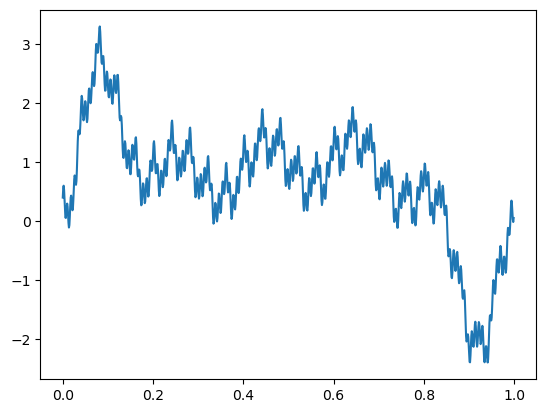

In [60]:
# Example: create a function to interpolate
test_func = lambda x: 0.4 * np.sin(10 * np.pi * x)\
                    + 0.1 * np.cos(99 * np.pi * x)\
                    + 0.3 * np.cos(50 * np.pi * x)\
                    + 0.2 * np.sin(250 * np.pi * x)\
                    + 4 * x * (1 - x)\
                    + 5e7 * x**3 * (1-x)**3 * (0.5-x)**3 * (0.25-x)**3 * (0.75-x)**3

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

plt.plot(xs, func_vals)
plt.show()


In [84]:
# MPS from tensor cross interpolation
#func = lambda *args: func_vals.reshape((2,)*10)[*args]
#here we have to define func as the initialization of the class
func = function(lambda *x: func_vals.reshape((2,) * 10)[*x])
As, _, eval, err_2, err_max = tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,      
                                   L=10,          # number of MPS tensors
                                   eps_or_chi=20, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))


38.7220856309729 3.2946521076008946


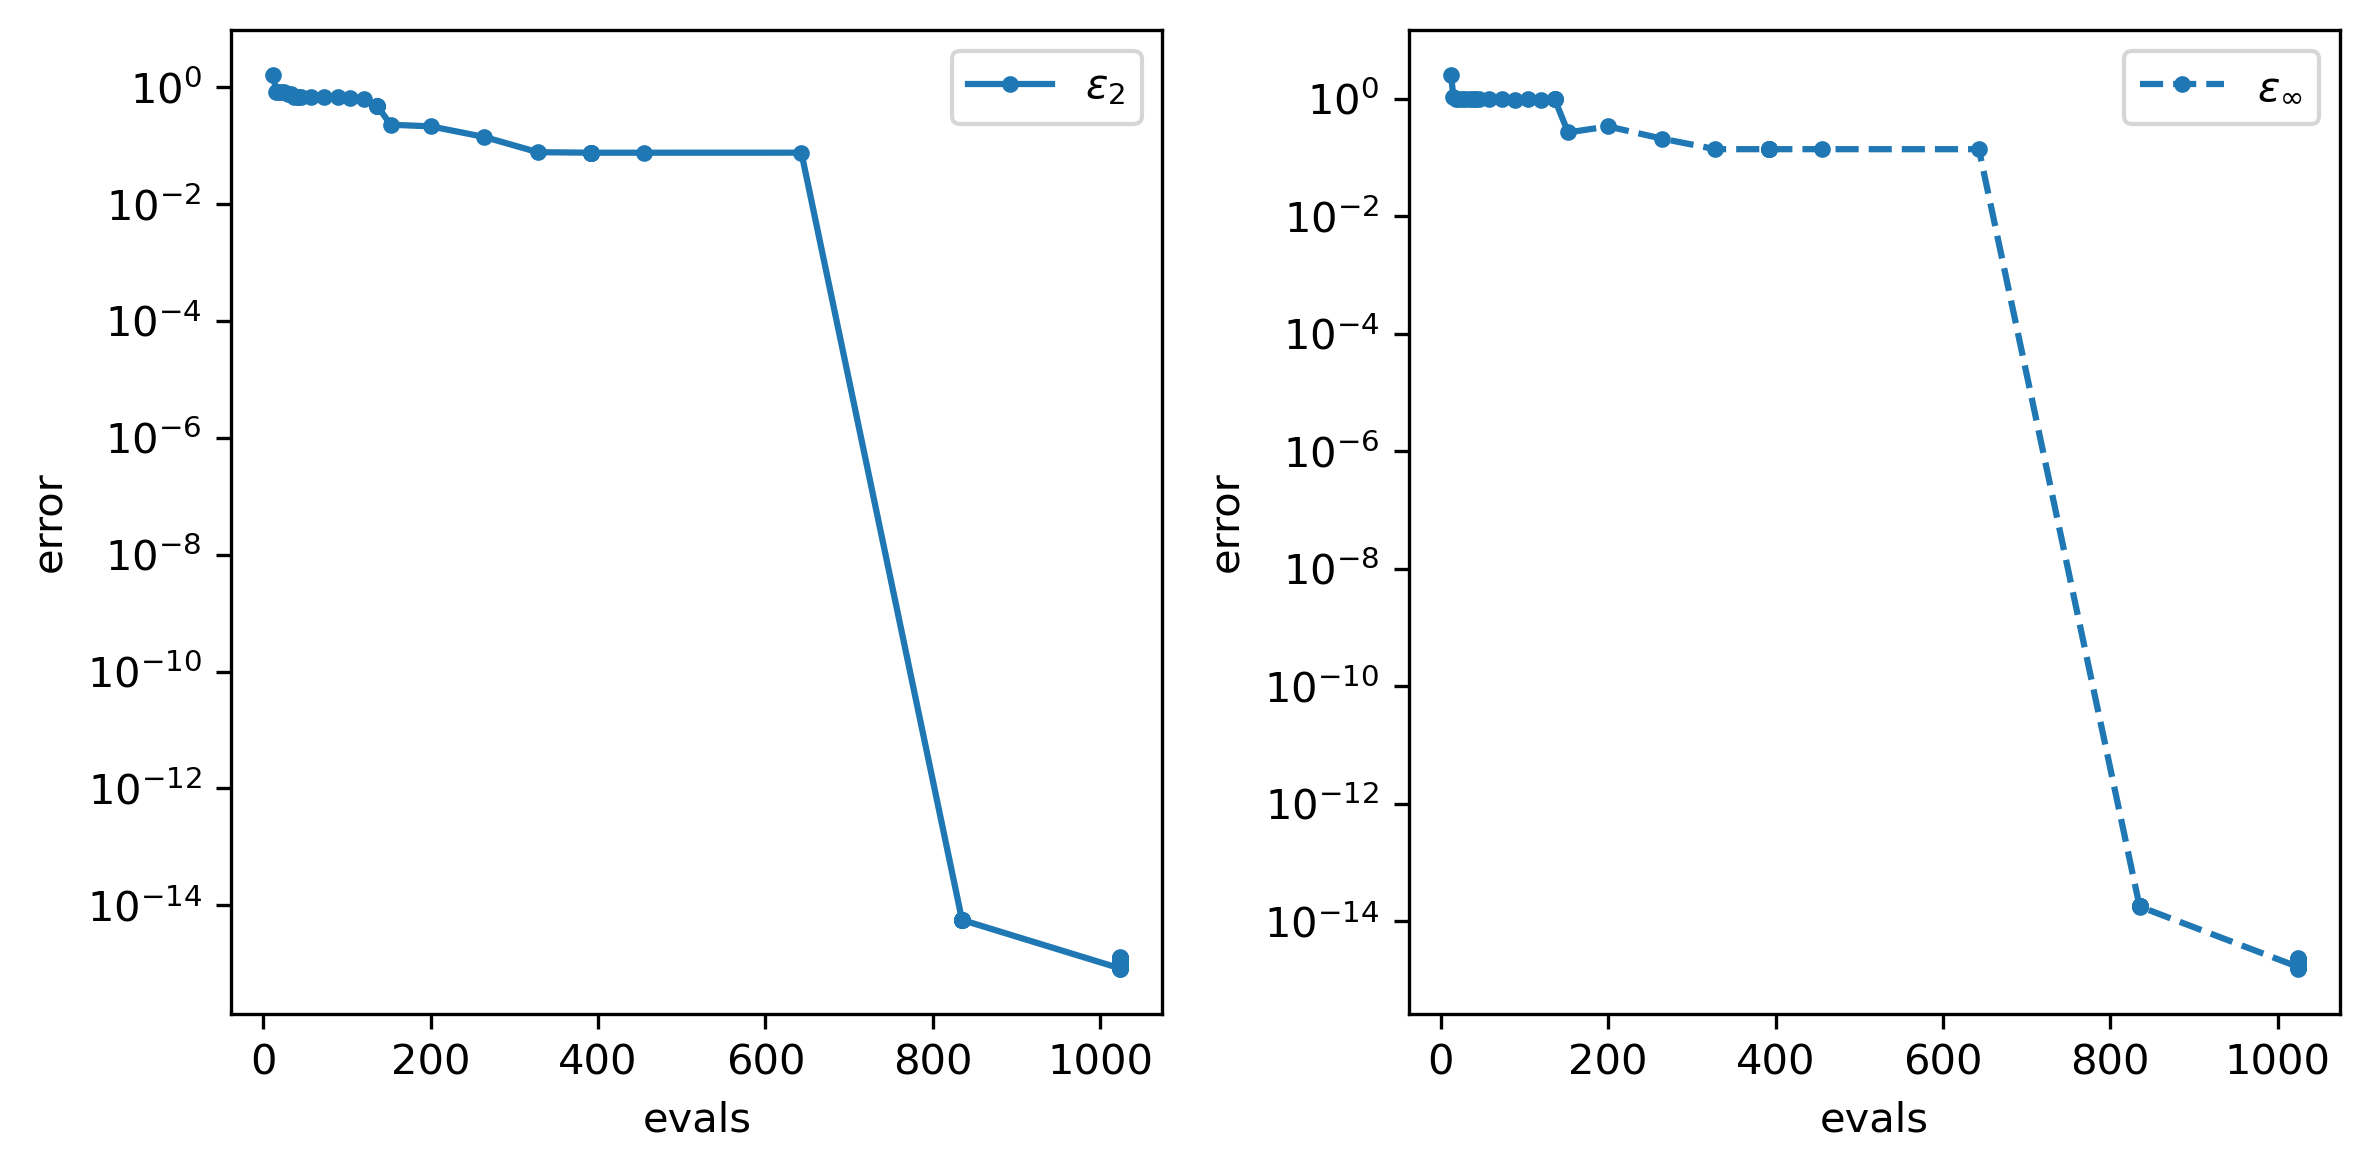

In [85]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), dpi=300)

axs[0].plot(eval, np.array(err_2), '.-', label = r"$\epsilon_2$")
axs[1].plot(eval, err_max, '.--', label = r"$\epsilon_\infty$")
axs[0].set(xlabel="evals",
           ylabel="error",
           #xscale="log",
           yscale="log",
           #ylim=(1e-5, 1e0)
           )
axs[1].set(xlabel="evals",
           ylabel="error",
           #xscale="log",
           yscale="log",
           #ylim=(1e-2,1e2)
           )
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()